# Scalable Diffusion Models with Transformer (DiT)

This notebook samples from pre-trained DiT models. DiTs are class-conditional latent diffusion models trained on ImageNet that use transformers in place of U-Nets as the DDPM backbone. DiT outperforms all prior diffusion models on the ImageNet benchmarks.

[Project Page](https://www.wpeebles.com/DiT) | [HuggingFace Space](https://huggingface.co/spaces/wpeebles/DiT) | [Paper](http://arxiv.org/abs/2212.09748) | [GitHub](github.com/facebookresearch/DiT)

# 1. Setup

We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the DiT GitHub repo and setup PyTorch. You only have to run this once.

In [1]:
# !git clone https://github.com/facebookresearch/DiT.git
import os

# Change to DiT directory if it exists (handle both cases: already in DiT or need to navigate to it)
if os.path.exists('DiT') and os.path.isdir('DiT'):
    os.chdir('DiT')
elif os.path.basename(os.getcwd()) != 'DiT':
    # If we're not in DiT and DiT doesn't exist as subdirectory, check if we need to clone it
    print("Warning: DiT directory not found. Make sure you've cloned the repository or are already in the DiT directory.")

# Set PYTHONPATH to include DiT directory
dit_path = os.getcwd() if os.path.basename(os.getcwd()) == 'DiT' else os.path.join(os.getcwd(), 'DiT')
os.environ['PYTHONPATH'] = os.pathsep.join([os.environ.get('PYTHONPATH', ''), dit_path]).strip(os.pathsep)

# !pip install diffusers timm --upgrade
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

/root/autodl-tmp/conda-env/dit/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download DiT-XL/2 Models

You can choose between a 512x512 model and a 256x256 model. You can swap-out the LDM VAE, too.

In [2]:
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-mse" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

/root/autodl-tmp/conda-env/dit/lib/python3.14/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


### VAE Encoding example

In [4]:
fake_image = torch.randn(1, 3, 256, 256, device=device)

print("Original image tensor:")
print(f"  Shape: {fake_image.shape}")
print()

with torch.no_grad():
    latent_dist = vae.encode(fake_image)
    latents = latent_dist.latent_dist.sample()
    
    latents = latents * 0.18215

print("Encoded latent tensor:")
print(f"  Shape: {latents.shape}")
print()

print("Verifying round-trip (encode -> decode):")
with torch.no_grad():
    decoded_latents = latents / 0.18215
    decoded_image = vae.decode(decoded_latents).sample

print(f"  Decoded image shape: {decoded_image.shape}")
print()

Original image tensor:
  Shape: torch.Size([1, 3, 256, 256])



Encoded latent tensor:
  Shape: torch.Size([1, 4, 32, 32])

Verifying round-trip (encode -> decode):
  Decoded image shape: torch.Size([1, 3, 256, 256])



# 2. Sample from Pre-trained DiT Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

100%|██████████| 250/250 [00:07<00:00, 31.89it/s]

torch.Size([1, 3, 256, 256])


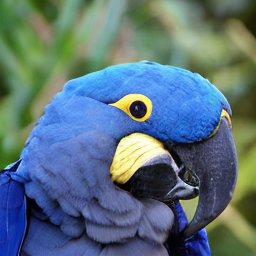

In [19]:
# Set user inputs:
single_image = True
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}

if not single_image:
    class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
    samples_per_row = 4 #@param {type:"number"}
else:
    class_labels = 88,
    samples_per_row = 1

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample
print(samples.shape)
# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

#  3. Play with intermediate representations

In [11]:
def print_intermediate_states(intermediate_states):
    """
    Print information about captured intermediate states from DiT blocks.
    """
    if intermediate_states is None:
        print("No intermediate states captured. Run forward with capture_intermediates=True")
        return

    print(f"\n=== DiT Intermediate States ===")
    print(f"Number of blocks: {len(intermediate_states)}")
    print()

    for i, state in enumerate(intermediate_states):
        print(f"Block {i+1}/{len(intermediate_states)}:")
        print(f"  Shape: {state.shape}")
        print(f"  Dtype: {state.dtype}")
        print(f"  Device: {state.device}")
        print(f"  Mean: {state.mean().item():.6f}")
        print(f"  Std: {state.std().item():.6f}")
        print(f"  Min: {state.min().item():.6f}")
        print(f"  Max: {state.max().item():.6f}")
        print()

In [12]:
# Test: Capture and print intermediate states of DiT blocks

# Create a test input
test_z = torch.randn(1, 4, latent_size, latent_size, device=device)
test_t = torch.tensor([50], device=device)  # timestep
test_y = torch.tensor([207], device=device)  # class label

print("Testing intermediate state capture...")
print(f"Input shape: {test_z.shape}")
print(f"Timestep: {test_t.item()}")
print(f"Class label: {test_y.item()}")
print(f"\nNumber of DiT blocks: {len(model.blocks)}")
print()

# Run forward pass with intermediate state capture
with torch.no_grad():
    output, intermediate_states = model.forward(test_z, test_t, test_y, capture_intermediates=True)

print(f"Output shape: {output.shape}")
print()

# Print intermediate states
print_intermediate_states(intermediate_states)



Testing intermediate state capture...
Input shape: torch.Size([1, 4, 32, 32])
Timestep: 50
Class label: 207

Number of DiT blocks: 28

Output shape: torch.Size([1, 8, 32, 32])


=== DiT Intermediate States ===
Number of blocks: 28

Block 1/28:
  Shape: torch.Size([1, 256, 1152])
  Dtype: torch.float32
  Device: cuda:0
  Mean: 0.338048
  Std: 6.205449
  Min: -206.812378
  Max: 28.018309

Block 2/28:
  Shape: torch.Size([1, 256, 1152])
  Dtype: torch.float32
  Device: cuda:0
  Mean: 0.362696
  Std: 7.805340
  Min: -225.097519
  Max: 157.110748

Block 3/28:
  Shape: torch.Size([1, 256, 1152])
  Dtype: torch.float32
  Device: cuda:0
  Mean: 0.399873
  Std: 11.413371
  Min: -339.269379
  Max: 174.420258

Block 4/28:
  Shape: torch.Size([1, 256, 1152])
  Dtype: torch.float32
  Device: cuda:0
  Mean: 0.186111
  Std: 18.970036
  Min: -608.702271
  Max: 174.443832

Block 5/28:
  Shape: torch.Size([1, 256, 1152])
  Dtype: torch.float32
  Device: cuda:0
  Mean: 0.117843
  Std: 22.467808
  Min: -7

# 4. Denoising with DiT: Add Noise and Denoise



Loading image from: /root/dinov2/dinov2/thirdparty/DiT/sample.png
Clean image shape: torch.Size([1, 3, 256, 256])
Clean image range: [0.000, 1.000]

Adding noise at timestep t=200 and denoising...
Noised image shape: torch.Size([1, 3, 256, 256])
Denoised image shape: torch.Size([1, 3, 256, 256])


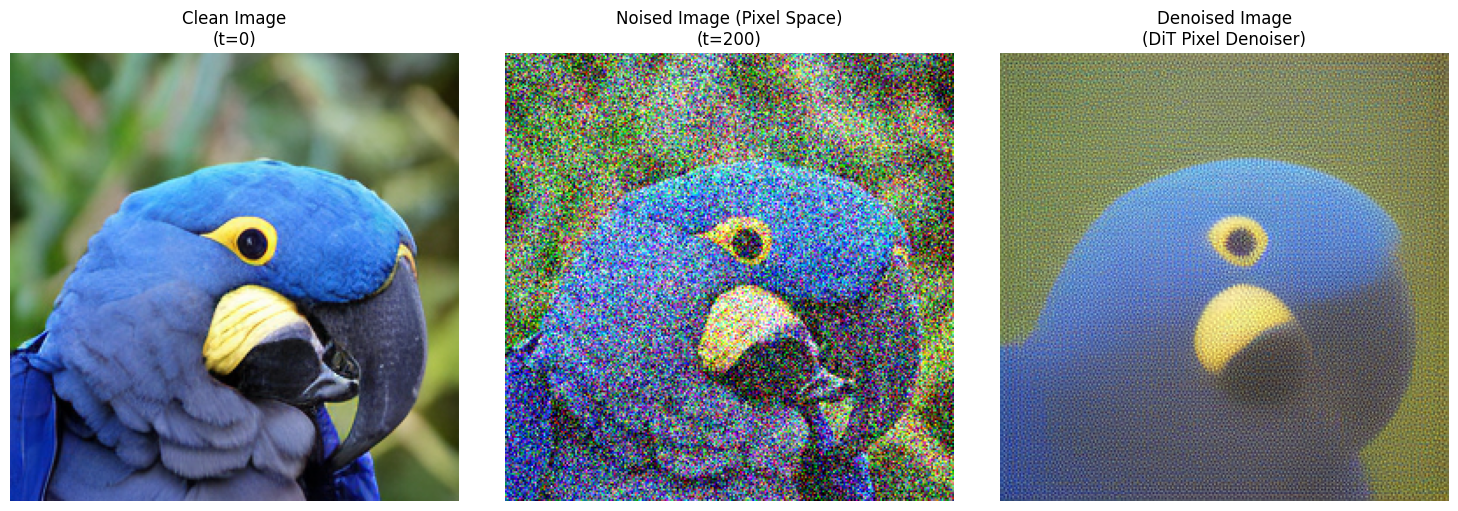

In [ ]:
import sys
import os
dinov2_root = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
if dinov2_root not in sys.path:
    sys.path.insert(0, dinov2_root)

from dinov2.dit_pixel_denoiser import DiTPixelDenoiser
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

timestep_t = 200  # @param {type:"slider", min:0, max:999, step:1}
use_real_image = True  # @param {type:"boolean"}
image_path = "/root/dinov2/dinov2/thirdparty/DiT/sample.png"  # @param {type:"string"}

denoiser = DiTPixelDenoiser(
    dit_model_path=find_model(f"DiT-XL-2-{image_size}x{image_size}.pt"),
    dit_model_name="DiT-XL/2",
    image_size=image_size,
    vae_model=vae_model,
    device=device
)

print(f"\nLoading image from: {image_path}")
image = Image.open(image_path).convert("RGB")
image = image.resize((image_size, image_size))
transform = transforms.Compose([transforms.ToTensor()])
clean_images = transform(image).unsqueeze(0).to(device)

print(f"Clean image shape: {clean_images.shape}")
print(f"Clean image range: [{clean_images.min():.3f}, {clean_images.max():.3f}]")

print(f"\nAdding noise at timestep t={timestep_t} and denoising...")
noised_images, denoised_images = denoiser.add_noise_and_denoise(
    clean_images, 
    timestep=timestep_t
)

print(f"Noised image shape: {noised_images.shape}")
print(f"Denoised image shape: {denoised_images.shape}")

clean_display = (clean_images + 1) / 2 if clean_images.min() < 0 else clean_images
clean_display = torch.clamp(clean_display, 0, 1)

noised_display = (noised_images + 1) / 2
noised_display = torch.clamp(noised_display, 0, 1)

denoised_display = (denoised_images + 1) / 2
denoised_display = torch.clamp(denoised_display, 0, 1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(clean_display[0].cpu().permute(1, 2, 0).numpy())
axes[0].set_title(f"Clean Image\n(t=0)")
axes[0].axis('off')

axes[1].imshow(noised_display[0].cpu().permute(1, 2, 0).numpy())
axes[1].set_title(f"Noised Image (Pixel Space)\n(t={timestep_t})")
axes[1].axis('off')

axes[2].imshow(denoised_display[0].cpu().permute(1, 2, 0).numpy())
axes[2].set_title(f"Denoised Image\n(DiT Pixel Denoiser)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

# save_image(clean_display, "clean_image_pixel.png", normalize=False)
# save_image(noised_display, "noised_image_pixel.png", normalize=False)
# save_image(denoised_display, "denoised_image_pixel.png", normalize=False)
# save_image(torch.cat([clean_display, noised_display, denoised_display], dim=0), 
#            "all_images_pixel.png", nrow=3, normalize=False)


# Noise Addition

In [ ]:
import numpy as np

image = "/root/dinov2/dinov2/thirdparty/DiT/sample.png"

# Load clean image
clean_img = Image.open(image).convert("RGB")

# Convert PIL image to numpy array in [0,1]
clean_np = np.asarray(clean_img).astype(np.float32) / 255.0

# Set noise standard deviation (25/255 for gauss25)
sigma = 50.0 / 255.0
np.random.seed(0)
noise = np.random.normal(0, sigma, clean_np.shape).astype(np.float32)
noisy_np = clean_np + noise
noisy_np = np.clip(noisy_np, 0.0, 1.0)

# Convert back to PIL for visualization
noisy_img = Image.fromarray((noisy_np * 255).astype(np.uint8))

# Save the noisy image
output_path = "/root/dinov2/dinov2/thirdparty/DiT/noisy_image.png"
noisy_img.save(output_path)